<a href="https://colab.research.google.com/github/JAYANTHNITW/Deep_Learning_Models/blob/main/Kaggle_example_code_on_Functional_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 314M/331M [00:01<00:00, 181MB/s]
100% 331M/331M [00:02<00:00, 136MB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip','r')
zip.extractall("/content")
zip.close()

In [5]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [8]:
folder_path ='/content/utkface_aligned_cropped/UTKFace'

In [9]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [12]:
df = pd.DataFrame({'age':age,'gender':gender,'img_path':img_path})

In [14]:
df.head()

,age,gender,img_path
0,10,0,10_0_0_20170110220251986.jpg.chip.jpg
1,14,0,14_0_0_20170110224445654.jpg.chip.jpg
2,43,1,43_1_4_20170117204025030.jpg.chip.jpg
3,38,1,38_1_0_20170104235617475.jpg.chip.jpg
4,36,1,36_1_0_20170104200945656.jpg.chip.jpg


In [13]:
df.shape

(23708, 3)

In [17]:
# sample()--> randomly picks rows from the dataset
# frac=1--> we want to sample the entire dataframe
# random_state=0--> we want sampling to be done in a consistent and reproducible way(so we get same results when we run the code again)
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [18]:
train_df.shape

(20000, 3)

In [19]:
test_df.shape

(3708, 3)

In [20]:
# Data Augumentation
train_datagen = ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)



In [42]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img_path',
                                                    y_col=['age','gender'],
                                                    targer_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=folder_path,
                                                  x_col = 'img_path',
                                                  y_col = ['age','gender'],
                                                  targe_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [31]:
train_datagen

In [23]:
from keras.applications import VGG16
from keras.layers import *
from keras.models import Model

In [48]:
vggnet = VGG16(include_top=False,input_shape=(256,256,3))

In [49]:
vggnet.trainable=False

output=vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [50]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [51]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

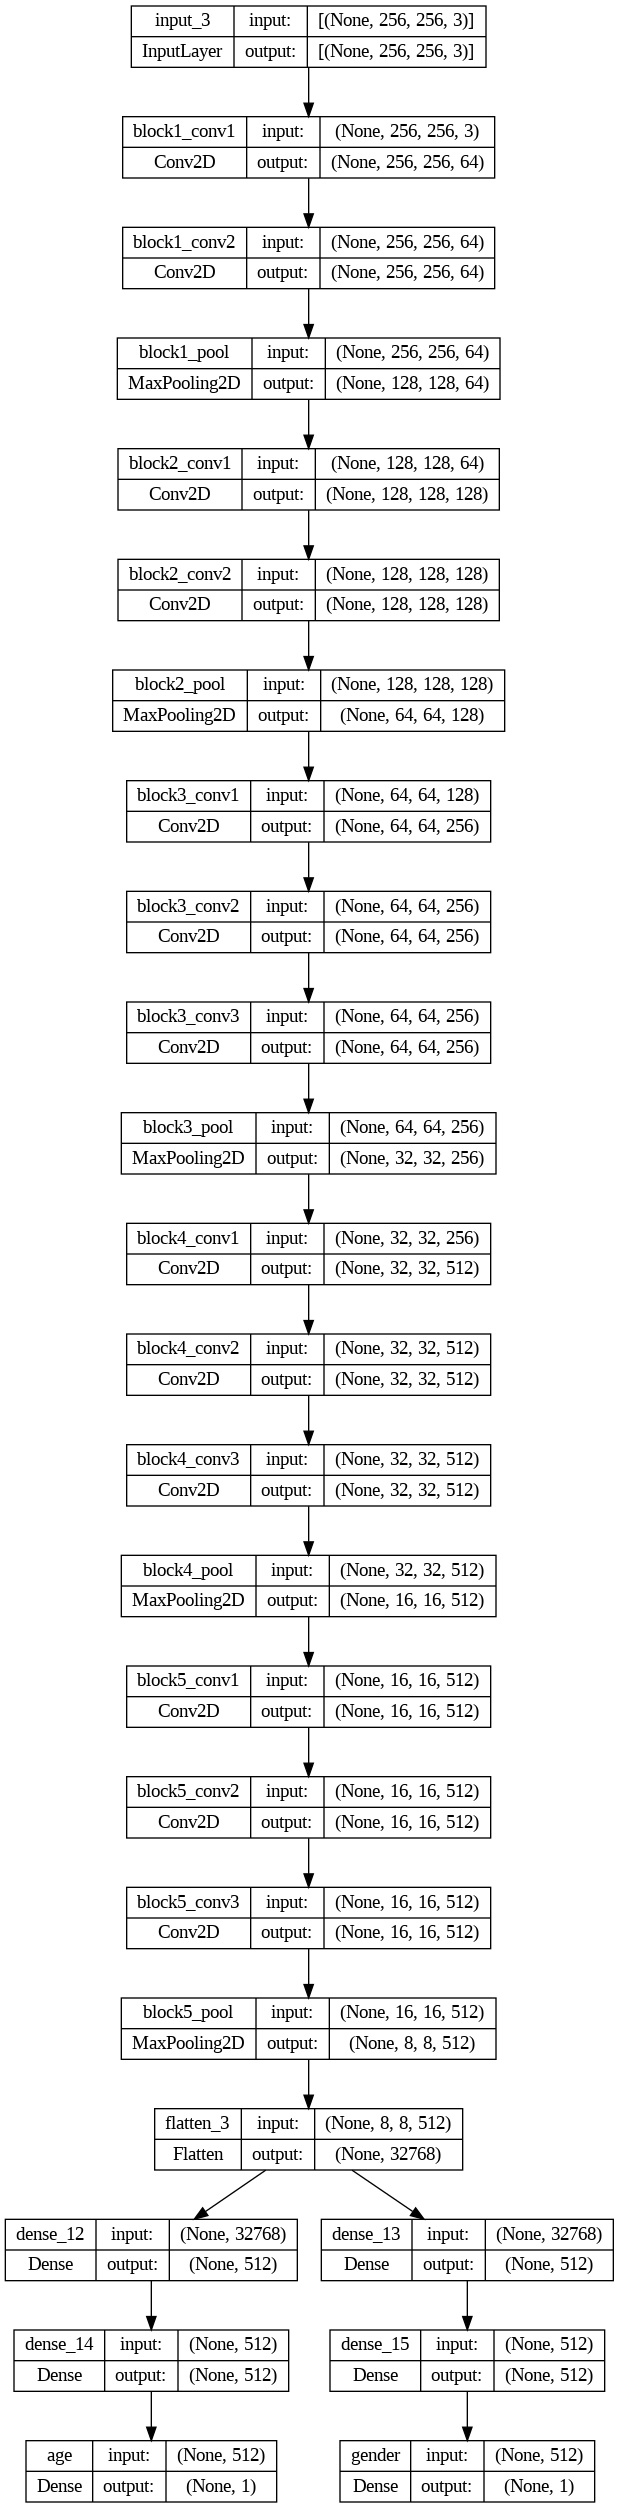

In [52]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [53]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})

In [ ]:
model.fit(train_generator,batch_size=32,validation_data=test_generator,epochs=10)

Epoch 1/10
  7/625 [..............................] - ETA: 10:24:05 - loss: 17.3301 - age_loss: 15.2942 - gender_loss: 2.0359 - age_mae: 15.2942 - gender_accuracy: 0.5268

In [40]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
